# 💡 SUPPLY / DEMAND INDICATOR

## 📌 Overview
This notebook link the two previously processed - supply (JOCAS) and demand (STMT) for the year 2020 - dataset in order to build a simple indicator of tension at the commune level (most granular possible). 

In [49]:
# Import Libraries
import pandas as pd
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt
import unidecode # To standardize strings
import re # For regular expression

In [19]:
# Get the project's root directory
base_folder = Path().resolve()  # Gets the current working directory
main_folder = base_folder.parent

# Importing files to be used in the script
stmt_path = main_folder / "data" / "2- Formatted Data" / "stmt_demand_processed.csv"
stmt = pd.read_csv(stmt_path)
jocas_path = main_folder / "data" / "2- Formatted Data" / "jocas_offers_processed.csv"
jocas = pd.read_csv(jocas_path)

# Specify the paths
output_file = main_folder / "data" / "2- Formatted Data" / "ratio_supply_demand.csv"  

In [121]:
#----------------------- MERGING BOTH DATASET ---------------------------#

df = jocas.merge(stmt, on=["commune", "fap87", "month"], how="outer")

# Reconcert to numeric and replace NA by 0 (if it's NA, there is no supply or demand)
df["job_offers_fap87"] = pd.to_numeric(df["job_offers_fap87"], errors='coerce').fillna(0).astype(int)
df["jobseekers_fap87"] = pd.to_numeric(df["jobseekers_fap87"], errors='coerce').fillna(0).astype(int)

# When there is no offer and some demand, the ratio of the two will be 0 (low tension) -> OK
df["job_offers_fap87"] = np.where(df["job_offers_fap87"] == 0, 0, df["job_offers_fap87"])

# When there is no demand and some offer, we replace 0 demand by 1 demand to avoid 0 division
df["jobseekers_fap87"] = np.where(df["jobseekers_fap87"] == 0, 1, df["jobseekers_fap87"])


#------------------------- COMPUTING RATIO ------------------------------#

df["offer/supply"] = df["job_offers_fap87"] / df["jobseekers_fap87"]


#------------------------- COMPUTING SCORE ------------------------------#

# Calculer les quintiles sur la population nationale
quintiles = df["offer/supply"].quantile([0.2, 0.4, 0.6, 0.8]).values

# Function to categorize the score safely
def discretize_offer_supply(x):
    if pd.isna(x):  # Gérer les valeurs manquantes
        return np.nan
    elif x <= quintiles[0]:
        return 1
    elif x <= quintiles[1]:
        return 2
    elif x <= quintiles[2]:
        return 3
    elif x <= quintiles[3]:
        return 4
    else:
        return 5

df["score"] = df["offer/supply"].apply(discretize_offer_supply)

In [122]:
df

,commune,fap87,month,job_offers_fap87,jobseekers_fap87,offer/supply,score
0,abbeville,A0Z,April,1,10,0.1,2
1,abbeville,A0Z,August,1,10,0.1,2
2,abbeville,A0Z,January,2,10,0.2,3
3,abbeville,A0Z,June,1,10,0.1,2
4,abbeville,A0Z,May,1,10,0.1,2
...,...,...,...,...,...,...,...
1233559,yzeure,V5Z,July,0,20,0.0,1
1233560,yzeure,V5Z,June,0,20,0.0,1
1233561,yzeure,V5Z,March,0,10,0.0,1
1233562,yzeure,V5Z,November,0,20,0.0,1


In [135]:
df[df["score"]==2]

,commune,fap87,month,job_offers_fap87,jobseekers_fap87,offer/supply,score
0,abbeville,A0Z,April,1,10,0.100000,2
1,abbeville,A0Z,August,1,10,0.100000,2
3,abbeville,A0Z,June,1,10,0.100000,2
4,abbeville,A0Z,May,1,10,0.100000,2
5,abbeville,A1Z,August,5,120,0.041667,2
...,...,...,...,...,...,...,...
963753,yzeure,T4Z,September,4,30,0.133333,2
963781,yzeure,V4Z,January,1,10,0.100000,2
963788,yzeure,V5Z,December,2,20,0.100000,2
963790,yzeure,V5Z,May,1,30,0.033333,2


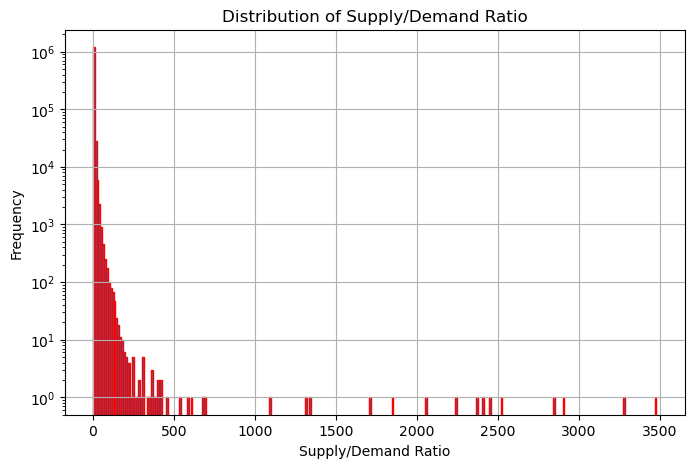

In [123]:
# Distribution of "job_offers_fap87"
plt.figure(figsize=(8, 5))
df["offer/supply"].hist(bins=300, edgecolor="red")
plt.yscale("log")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Supply/Demand Ratio")
plt.show()

In [124]:
# Distribution of "job_offers_fap87"
plt.figure(figsize=(8, 5))
df["standard_ratio"].hist(bins=300, edgecolor="red")
plt.yscale("log")
plt.xlabel("Supply/Demand Ratio")
plt.ylabel("Frequency")
plt.title("Distribution of Supply/Demand Ratio")
plt.show()

KeyError: 'standard_ratio'

<Figure size 800x500 with 0 Axes>